<h1> Animal Faces <span class="tocSkip"></span></h1>

<h1> Задача: <span class="tocSkip"></span></h1>

Используя датасет https://www.kaggle.com/datasets/andrewmvd/animal-faces:

- Вычислить средние и дисперсии по выборке обучающего датасета и применить их для того, чтобы производить более качественную предобработку данных.

- Используя библиотеку albumentations, добавить дополнительные аугментации на обучающий датасет (изменение контрастности, шум и т.д).

- Импортировать предобученную нейронную сеть vgg16 из pytorch и заморозить протекание градиента по нейронной сети, после чего заменить последний линейный слой.

- Импортировать предобученную нейронную сеть AlexNet из pytorch и использовать без заморозки весов.

- Сделать выводы о качестве моделей.

# Импорт всех необходимых библиотек и подключение к GDrive

In [1]:
import numpy as np
import copy
import random
import os
from tqdm import tqdm

import matplotlib.pyplot as plt
from IPython.display import clear_output
from PIL import Image

import torch
import torch.nn as nn
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam, lr_scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import transforms
import torchvision.models as models
from torchvision.models import vgg16
from torchsummary import summary

from sklearn.metrics import classification_report, accuracy_score

import cv2
from google.colab.patches import cv2_imshow

import albumentations as A
from albumentations.pytorch import ToTensorV2

In [2]:
SEED = 261222
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)

In [3]:
print(os.getcwd())

/content


In [4]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

!nvidia-smi

CUDA is available!  Training on GPU ...
cuda
Wed Jan 11 06:42:06 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8    10W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                           

In [5]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [6]:
!unzip -q /content/gdrive/My\ Drive/Animal_Faces/archive.zip -d arch

In [7]:
!ls arch 

afhq


## Загрука датасетов и расчет среднего и стандартного отклонения по выборке обучающего датасета

In [8]:
my_transform_train = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize(128)        
    ]
)

In [9]:
train_dataset = ImageFolder(root='/content/arch/afhq/train', transform=my_transform_train)

In [10]:
len(train_dataset)

14630

In [11]:
batch_size = 256
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [12]:
next(iter(train_dataloader))[0].to(device).shape

torch.Size([256, 3, 128, 128])

## Поиск среднего и стандартного отклонения

Посчитаем среднее и стандартное отклонение по одному батчу и переведем эти значения в кортеж.

In [13]:
#model.forward(next(iter(train_dataloader))[0].to(device)).shape

In [14]:
#next(iter(train_dataloader))[0].to(device).sum(axis = 0).sum(1).sum(1)/(32*32)/batch_size

In [15]:
#torch.mean(next(iter(train_dataloader))[0][0], dim = [1,2])

In [16]:
#torch.std(next(iter(train_dataloader))[0][0], dim = [1,2])

In [17]:
mean = torch.mean(torch.mean(next(iter(train_dataloader))[0], dim = 0), dim = [1,2])
mean

tensor([0.4984, 0.4543, 0.3974])

In [18]:
mean = [round(m, 3) for m in mean.tolist()]
mean = tuple(mean)
mean

(0.498, 0.454, 0.397)

In [19]:
std = torch.std(torch.mean(next(iter(train_dataloader))[0], dim = 0), dim = [1,2])
std

tensor([0.0261, 0.0239, 0.0239])

In [20]:
std = [round(m, 3) for m in std.tolist()]
std = tuple(std)
std

(0.026, 0.024, 0.024)

## Загрузка основных датасетов для аугментации-трансформации

In [21]:
train_directory_cat = '/content/arch/afhq/train/cat'
train_directory_dog = '/content/arch/afhq/train/dog'
train_directory_wild = '/content/arch/afhq/train/wild'
val_directory_cat = '/content/arch/afhq/val/cat'
val_directory_dog = '/content/arch/afhq/val/dog'
val_directory_wild = '/content/arch/afhq/val/wild'

In [22]:
train_cat_images_filepaths = sorted([os.path.join(train_directory_cat, f) for f in os.listdir(train_directory_cat)])
train_dog_images_filepaths = sorted([os.path.join(train_directory_dog, f) for f in os.listdir(train_directory_dog)])
train_wild_images_filepaths = sorted([os.path.join(train_directory_wild, f) for f in os.listdir(train_directory_wild)])
train_images_filepaths = [*train_cat_images_filepaths, *train_dog_images_filepaths, *train_wild_images_filepaths]

#random.seed(42)
random.shuffle(train_images_filepaths)

In [23]:
val_cat_images_filepaths = sorted([os.path.join(val_directory_cat, f) for f in os.listdir(val_directory_cat)])
val_dog_images_filepaths = sorted([os.path.join(val_directory_dog, f) for f in os.listdir(val_directory_dog)])
val_wild_images_filepaths = sorted([os.path.join(val_directory_wild, f) for f in os.listdir(val_directory_wild)])
val_images_filepaths = [*val_cat_images_filepaths, *val_dog_images_filepaths, *val_wild_images_filepaths]

#random.seed(42)
random.shuffle(val_images_filepaths)

print(len(train_images_filepaths), len(val_images_filepaths))

14630 1500


In [24]:
val_images_filepaths[:3]

['/content/arch/afhq/val/dog/pixabay_dog_001358.jpg',
 '/content/arch/afhq/val/wild/flickr_wild_003840.jpg',
 '/content/arch/afhq/val/dog/flickr_dog_000425.jpg']

In [25]:
def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        true_label = os.path.normpath(image_filepath).split(os.sep)[-2]
        predicted_label = predicted_labels[i] if predicted_labels else true_label
        color = "green" if true_label == predicted_label else "red"
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(predicted_label, color=color)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

Посмотрим на рандомные 10 картинок.
Красивенькие =)

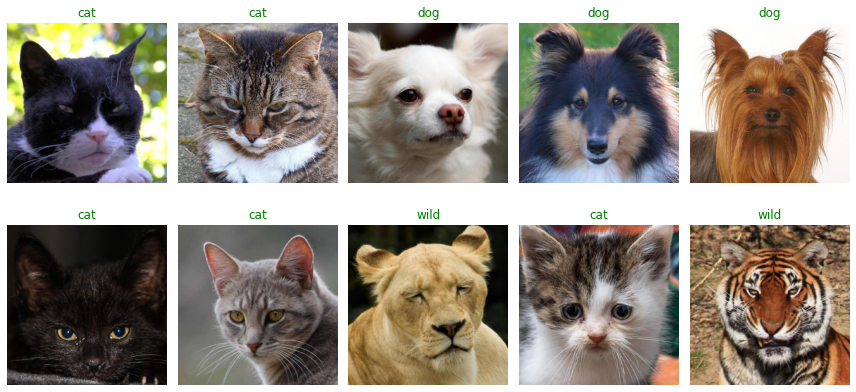

In [26]:
display_image_grid(val_images_filepaths[10:20])

Отлично, теперь у нас есть большой список со ссылками на картинки. 

## Ресайз, нормализация и аугментация

Создадим класс, в котором будут происходить трансформации, аугментации и кодирование лэйблов (названий классов).

In [27]:
class CatsVsDogsDataset(Dataset):
    def __init__(self, images_filepaths, transform=None):
        self.images_filepaths = images_filepaths
        self.transform = transform

    def __len__(self):
        return len(self.images_filepaths)

    def __getitem__(self, idx):
        image_filepath = self.images_filepaths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if os.path.normpath(image_filepath).split(os.sep)[-2] == "cat":
            label = 1
        elif os.path.normpath(image_filepath).split(os.sep)[-2] == "dog":
            label = 0
        else:    
            label = 2
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        return image, label

In [28]:
train_transform = A.Compose(
    [
        A.SmallestMaxSize(max_size=160),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.RandomCrop(height=128, width=128),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ]
)

test_transform = A.Compose(
    [
        A.SmallestMaxSize(max_size=160),
        A.CenterCrop(height=128, width=128),
        A.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ]
)

In [29]:
train_dataset = CatsVsDogsDataset(images_filepaths=train_images_filepaths, transform=train_transform)
val_dataset = CatsVsDogsDataset(images_filepaths=val_images_filepaths, transform=test_transform)

Визуализируем наши аугментации.

In [30]:
def visualize_augmentations(dataset, idx, samples=10, cols=5):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i in range(samples):
        image, _ = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

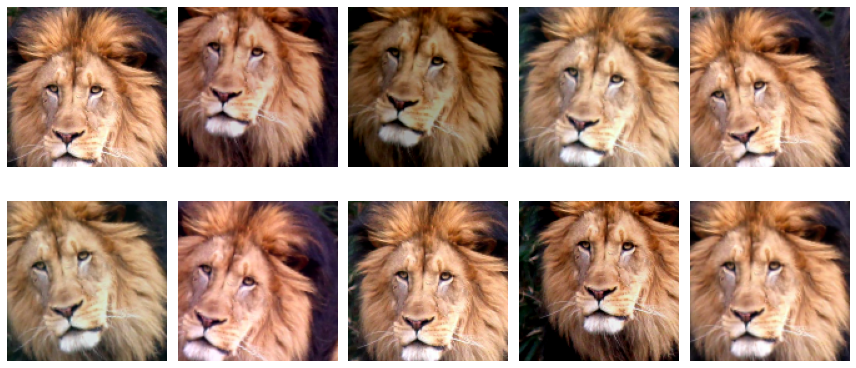

In [31]:
idx = random.randint(1,len(train_dataset))
visualize_augmentations(train_dataset, idx)

# Обучение

## Наша игрушечная модель

### Объявление даталоадеров

In [32]:
my_transform_train = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize(32),
        transforms.Normalize(mean=mean,
                             std=std),
        transforms.RandomRotation((-10, 10)),
        transforms.RandomHorizontalFlip(p=0.5)
    ]
)
my_transform_test = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize(32),
        transforms.Normalize(mean=mean,
                             std=std)
    ]
)

In [33]:
train_dataset_mm = ImageFolder(root='/content/arch/afhq/train', transform=my_transform_train)
val_dataset_mm = ImageFolder(root='/content/arch/afhq/val', transform=my_transform_test)

In [34]:
batch_size = 64
train_dataloader_mm = DataLoader(train_dataset_mm, batch_size=batch_size, shuffle=True, drop_last=True)
val_dataloader_mm = DataLoader(val_dataset_mm, batch_size=batch_size, shuffle=False, drop_last=False)

In [35]:
(next(iter(train_dataloader_mm))[0].to(device)).shape

torch.Size([64, 3, 32, 32])

### Архитектура модели

In [36]:
class MyCNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=3)
        self.conv2 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=2, padding=1)
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv3 = torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=2, padding=1)
        self.pool3 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv4 = torch.nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=0)
        self.linear1 = torch.nn.Linear(256, 64)
        self.linear2 = torch.nn.Linear(64, 16)
        self.linear3 = torch.nn.Linear(16, 3)
        # self.softmax = torch.nn.Softmax(dim=1)
        self.relu = torch.nn.ReLU()
    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.pool3(x)
        x = self.relu(x)
        x = self.conv4(x).squeeze(2).squeeze(2)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        # x = self.softmax(x)
        return x

In [37]:
mm_model = MyCNN().to(device)

In [38]:
summary(mm_model.to(device), (3, 32, 32) )

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
         MaxPool2d-2           [-1, 32, 10, 10]               0
              ReLU-3           [-1, 32, 10, 10]               0
            Conv2d-4           [-1, 64, 11, 11]           8,256
         MaxPool2d-5             [-1, 64, 5, 5]               0
              ReLU-6             [-1, 64, 5, 5]               0
            Conv2d-7            [-1, 128, 6, 6]          32,896
         MaxPool2d-8            [-1, 128, 3, 3]               0
              ReLU-9            [-1, 128, 3, 3]               0
           Conv2d-10            [-1, 256, 1, 1]         295,168
           Linear-11                   [-1, 64]          16,448
             ReLU-12                   [-1, 64]               0
           Linear-13                   [-1, 16]           1,040
             ReLU-14                   

In [39]:
mm_model.forward(next(iter(train_dataloader_mm))[0].to(device)).shape

torch.Size([64, 3])

In [40]:
NUM_EPOCHS = 15
lr = 0.001
mm_model = MyCNN().to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = Adam(mm_model.parameters(), lr=lr)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

### Функция для обучения, проверки на валидации и построения графика

In [41]:
def train(model, train_dataloader, val_dataloader, optimizer, epochs, learning_rate, scheduler):  
  train_loss = []
  val_loss = []
  pred = []
  val_acc = []

  for epoch in tqdm(range(epochs)):

      model.train(True)
      train_loss_epoch = 0
      val_loss_epoch = 0

      for X, y in train_dataloader:
          #print(X.shape)
          #print(y.shape)
          model.zero_grad()
          features = X.to(device)
          target = y.to(device)
          predictions = model(features)
          loss = loss_function(predictions, target)
          loss.backward()
          train_loss_epoch += loss.item()/len(train_dataloader)
          optimizer.step()

      train_loss.append(train_loss_epoch)

      preds = []
      targets = []
      model.train(False)
      model.eval()

      with torch.no_grad():
          for X, y in val_dataloader:
              features = X.to(device)
              target = y.to(device)
              predictions = model(features)
              loss = loss_function(predictions, target)
              val_loss_epoch += loss.item()/len(val_dataloader)
              preds.append(predictions.argmax(axis = 1).detach().cpu().numpy())
              targets.append(target.cpu().numpy())

      if scheduler is not None:
          scheduler.step()

      val_loss.append(val_loss_epoch)
      val_acc.append(accuracy_score(np.concatenate(targets), np.concatenate(preds)))

      fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
      clear_output(True)
      if train_loss is not None:
          ax.plot(train_loss, label='general train history')
          ax.set_xlabel('Epoch')
          ax.set_title('Train and Val loss')
      if val_loss is not None:
          ax.plot(val_loss, label='general valid history')
      plt.legend()
      plt.show()  

      print(f'\nEpoch: {epoch+1:01}')
      print(f'Train Loss: {train_loss[epoch]:.3f}')
      print(f' Val. Loss: {val_loss[epoch]:.3f} | Val.ACC: {val_acc[epoch]:.3f}')

  return train_loss, val_loss, val_acc

### Обучение

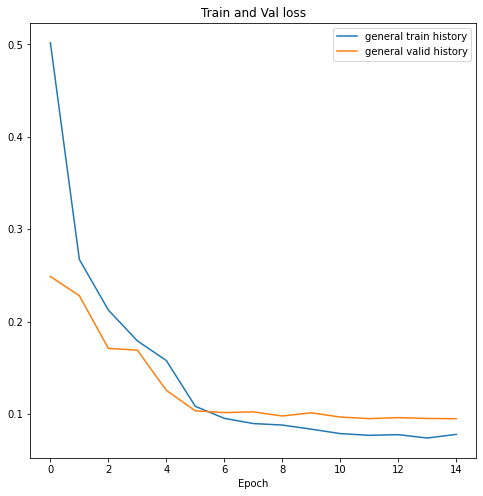

100%|██████████| 15/15 [26:38<00:00, 106.57s/it]


Epoch: 15
Train Loss: 0.078
 Val. Loss: 0.095 | Val.ACC: 0.967


In [42]:
mm_train_history, mm_val_history, mm_val_acc = train(mm_model, 
                                                     train_dataloader=train_dataloader_mm, 
                                                     val_dataloader=val_dataloader_mm, 
                                                     optimizer=optimizer, 
                                                     epochs=NUM_EPOCHS, 
                                                     learning_rate = lr, 
                                                     scheduler=exp_lr_scheduler)

### Сохранение весов модели

In [43]:
torch.save(mm_model.state_dict(), 'mm_model.pth')

## VGG16

### Объявление даталоадеров

In [44]:
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

In [45]:
for (X, y) in val_dataloader:
  print(X.shape, y.shape)
  print(y)
  break

torch.Size([64, 3, 128, 128]) torch.Size([64])
tensor([0, 2, 0, 1, 2, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 2, 1, 2, 0, 0, 2, 2,
        0, 0, 1, 0, 2, 0, 1, 1, 0, 2, 1, 2, 0, 0, 0, 1, 1, 1, 0, 0, 2, 1, 2, 1,
        1, 1, 1, 1, 0, 1, 1, 2, 2, 2, 2, 0, 2, 0, 2, 2])


### Загрузка модели VGG16

In [46]:
model_extractor = models.vgg16(pretrained=True)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [47]:
model_extractor

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Заморозка весов модели и замена слоев

In [48]:
# замораживаем параметры (веса)
for param in model_extractor.parameters():
    param.requires_grad = False

Видим, что в классификаторе 25088 выходов. Ок. Значит на последний слой нашей модели мы должны подавать именно столько параметров. А на выходе у нас 3 класса (котики, собаки и дикие).

In [49]:
num_features = 25088
num_classes = 3

model_extractor.classifier = nn.Sequential(
    nn.Linear(in_features=num_features, out_features=8192, bias=True),
    nn.Dropout(p=0.5),
    nn.ReLU(inplace=True))

model_extractor.classifier.append(nn.Sequential(
    nn.Linear(in_features=8192, out_features=4096, bias=True),
    torch.nn.Dropout(p=0.5),
    nn.ReLU(inplace=True),
))

model_extractor.classifier.append(nn.Sequential(
    nn.Linear(in_features=4096, out_features=2048, bias=True),
    torch.nn.Dropout(p=0.5),
    nn.ReLU(inplace=True),
))

model_extractor.classifier.append(nn.Sequential(
    nn.Linear(in_features=2048, out_features=1000, bias=True),
    torch.nn.Dropout(p=0.5),
    nn.ReLU(inplace=True),
))

model_extractor.classifier.append(nn.Linear(in_features=1000, out_features=num_classes, bias=True)) 

Sequential(
  (0): Linear(in_features=25088, out_features=8192, bias=True)
  (1): Dropout(p=0.5, inplace=False)
  (2): ReLU(inplace=True)
  (3): Sequential(
    (0): Linear(in_features=8192, out_features=4096, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): ReLU(inplace=True)
  )
  (4): Sequential(
    (0): Linear(in_features=4096, out_features=2048, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): ReLU(inplace=True)
  )
  (5): Sequential(
    (0): Linear(in_features=2048, out_features=1000, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): ReLU(inplace=True)
  )
  (6): Linear(in_features=1000, out_features=3, bias=True)
)

In [50]:
model_extractor

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Проверим, что при подаче нашего изображения размером (3, 128, 128) модель будет работать корректно.

In [51]:
summary(model_extractor.to(device), (3, 128, 128) )

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
              ReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3         [-1, 64, 128, 128]          36,928
              ReLU-4         [-1, 64, 128, 128]               0
         MaxPool2d-5           [-1, 64, 64, 64]               0
            Conv2d-6          [-1, 128, 64, 64]          73,856
              ReLU-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 128, 64, 64]         147,584
              ReLU-9          [-1, 128, 64, 64]               0
        MaxPool2d-10          [-1, 128, 32, 32]               0
           Conv2d-11          [-1, 256, 32, 32]         295,168
             ReLU-12          [-1, 256, 32, 32]               0
           Conv2d-13          [-1, 256, 32, 32]         590,080
             ReLU-14          [-1, 256,

### Обучение

In [52]:
NUM_EPOCHS = 10
lr = 0.0001
model = model_extractor.to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = Adam(model.classifier.parameters(), lr=lr)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

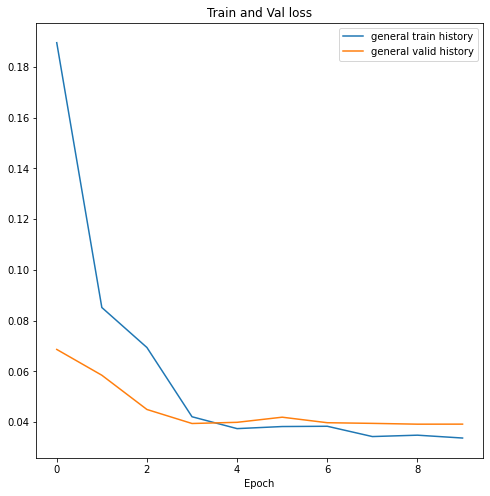

100%|██████████| 10/10 [22:06<00:00, 132.64s/it]


Epoch: 10
Train Loss: 0.034
 Val. Loss: 0.039 | Val.ACC: 0.991


In [53]:
train_history, val_history, val_acc = train(model, 
                                            train_dataloader=train_dataloader,
                                            val_dataloader=val_dataloader, 
                                            optimizer=optimizer, 
                                            epochs=NUM_EPOCHS, 
                                            learning_rate = lr, 
                                            scheduler=exp_lr_scheduler)

### Сохранение весов модели

In [54]:
torch.save(model.state_dict(), 'Pretrained-VGG16-model.pth')

### Загрузка весов модели обратно

In [55]:
model.load_state_dict(torch.load('Pretrained-VGG16-model.pth'))

<All keys matched successfully>

In [56]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## Alexnet БЕЗ ЗАМОРОЗКИ ВЕСОВ

### Загрузка модели AlexNet

In [57]:
model_alex = models.alexnet(pretrained=True)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [58]:
model_alex

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [59]:
num_features = 9216
n_classes = 3
lr = 1e-4
NUM_EPOCHS = 5

model_alex.classifier = nn.Linear(num_features, n_classes)
model_alex = model_alex.to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_alex.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [60]:
summary(model_alex.to(device), (3, 128, 128) )

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 31, 31]          23,296
              ReLU-2           [-1, 64, 31, 31]               0
         MaxPool2d-3           [-1, 64, 15, 15]               0
            Conv2d-4          [-1, 192, 15, 15]         307,392
              ReLU-5          [-1, 192, 15, 15]               0
         MaxPool2d-6            [-1, 192, 7, 7]               0
            Conv2d-7            [-1, 384, 7, 7]         663,936
              ReLU-8            [-1, 384, 7, 7]               0
            Conv2d-9            [-1, 256, 7, 7]         884,992
             ReLU-10            [-1, 256, 7, 7]               0
           Conv2d-11            [-1, 256, 7, 7]         590,080
             ReLU-12            [-1, 256, 7, 7]               0
        MaxPool2d-13            [-1, 256, 3, 3]               0
AdaptiveAvgPool2d-14            [-1, 25

### Обучение

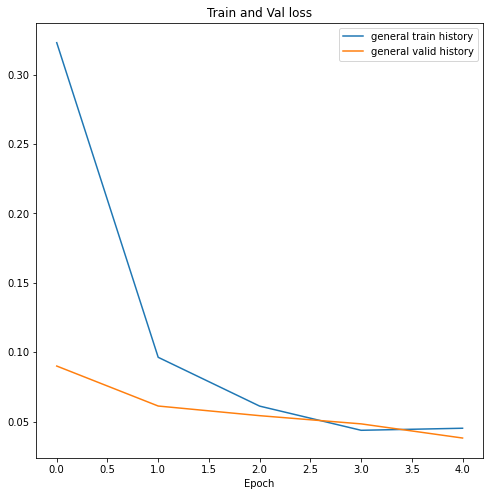

100%|██████████| 5/5 [07:18<00:00, 87.68s/it]


Epoch: 5
Train Loss: 0.045
 Val. Loss: 0.038 | Val.ACC: 0.993


In [61]:
train_history_alex, val_history_alex, val_acc_alex = train(model_alex, 
                                            train_dataloader=train_dataloader,
                                            val_dataloader=val_dataloader, 
                                            optimizer=optimizer, 
                                            epochs=NUM_EPOCHS, 
                                            learning_rate = lr, 
                                            scheduler=exp_lr_scheduler)

In [62]:
torch.save(model_alex.state_dict(), 'Pretrained-Alexnet-model.pth')

## Вывод метрик модели

### Игрушечная самописная модель

In [63]:
mm_model.eval()

preds = []
real = []
for x, y in val_dataloader_mm:
    preds.append(mm_model.forward(x.to(device)).detach().cpu().numpy())
    real.append(y.numpy())

In [64]:
final_preds = np.concatenate(preds).argmax(axis=1)
real = np.concatenate(real)

In [65]:
print(classification_report(real, final_preds))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       500
           1       0.96      0.97      0.97       500
           2       0.98      0.96      0.97       500

    accuracy                           0.97      1500
   macro avg       0.97      0.97      0.97      1500
weighted avg       0.97      0.97      0.97      1500



### VGG16 c переобученным классификатором

In [66]:
model.eval()

preds = []
real = []
for x, y in val_dataloader:
    preds.append(model.forward(x.to(device)).detach().cpu().numpy())
    real.append(y.numpy())

In [67]:
final_preds = np.concatenate(preds).argmax(axis=1)
real = np.concatenate(real)

In [68]:
print(classification_report(real, final_preds))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       500
           1       1.00      0.99      1.00       500
           2       0.99      0.98      0.99       500

    accuracy                           0.99      1500
   macro avg       0.99      0.99      0.99      1500
weighted avg       0.99      0.99      0.99      1500



### AlexNet c переобученным классификатором

In [69]:
model_alex.eval()

preds = []
real = []
for x, y in val_dataloader:
    preds.append(model_alex.forward(x.to(device)).detach().cpu().numpy())
    real.append(y.numpy())

In [70]:
final_preds = np.concatenate(preds).argmax(axis=1)
real = np.concatenate(real)

In [71]:
print(classification_report(real, final_preds))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       500
           1       1.00      1.00      1.00       500
           2       0.99      0.99      0.99       500

    accuracy                           0.99      1500
   macro avg       0.99      0.99      0.99      1500
weighted avg       0.99      0.99      0.99      1500



## Предсказание на тесте ( вообще функция подойдет для любой картинки, до нее нужно лишь указать путь)

Далее в этом разделе mm_model - это наша самописная модель, а model - это обученные vgg16.

Можно будет увидеть, что vgg16 в отличие от нашей самописной модели, ошибается гораздо чаще.

In [72]:
dict_names = {
    0: 'Кошка',
    1: 'Собака',
    2: 'Дикая'
}

In [73]:
def predict_by_path(path, model):
    image = Image.open(path)
    image_np =  np.array(image)
    pred = model.forward(my_transform_train(image_np).to(device).unsqueeze(0)).cpu().detach().numpy()[0]
    plt.imshow(image)
    res = np.argmax(pred)
    print(dict_names[res])

Кошка


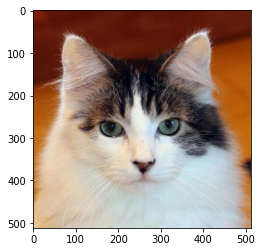

In [ ]:
model.eval()
predict_by_path('/content/arch/afhq/val/cat/flickr_cat_000008.jpg', model)

Собака


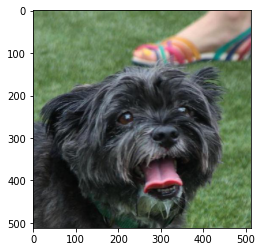

In [ ]:
mm_model.eval()
predict_by_path('/content/arch/afhq/val/dog/flickr_dog_000060.jpg', mm_model)

Кошка


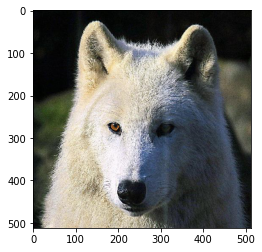

In [ ]:
model.eval()
predict_by_path('/content/arch/afhq/val/wild/flickr_wild_000470.jpg', model)

Кошка


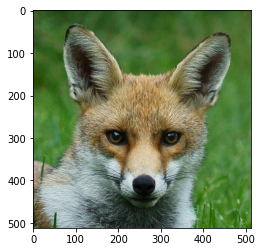

In [74]:
predict_by_path('/content/arch/afhq/val/wild/flickr_wild_000039.jpg', model)

Дикая


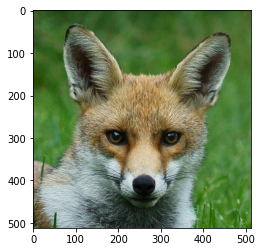

In [75]:
predict_by_path('/content/arch/afhq/val/wild/flickr_wild_000039.jpg', mm_model)

Кошка


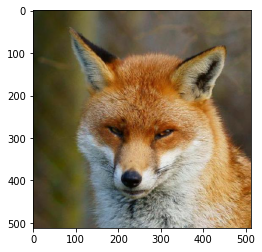

In [76]:
predict_by_path('/content/arch/afhq/val/wild/flickr_wild_000040.jpg', model)

Дикая


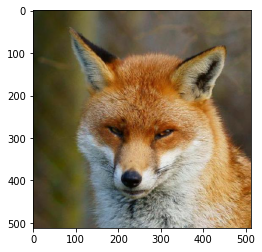

In [77]:
predict_by_path('/content/arch/afhq/val/wild/flickr_wild_000040.jpg', mm_model)

Собака


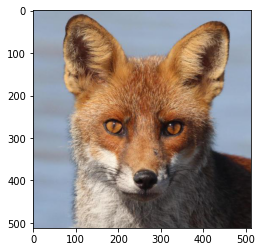

In [ ]:
predict_by_path('/content/arch/afhq/val/wild/flickr_wild_000064.jpg', model)

Дикая


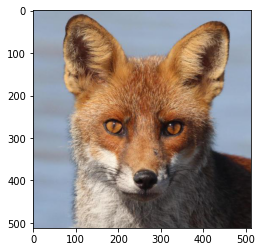

In [ ]:
predict_by_path('/content/arch/afhq/val/wild/flickr_wild_000064.jpg', mm_model)

Кошка


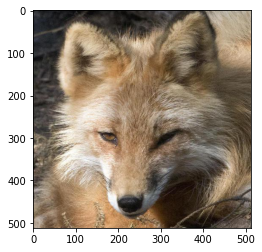

In [ ]:
predict_by_path('/content/arch/afhq/val/wild/flickr_wild_000206.jpg', model)

Дикая


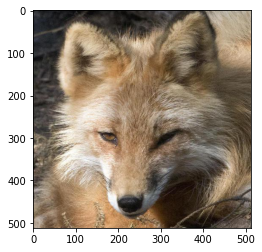

In [ ]:
predict_by_path('/content/arch/afhq/val/wild/flickr_wild_000206.jpg', mm_model)

Кошка


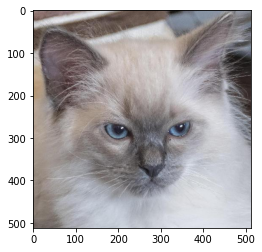

In [ ]:
predict_by_path('/content/arch/afhq/val/cat/flickr_cat_000162.jpg', model)

Собака


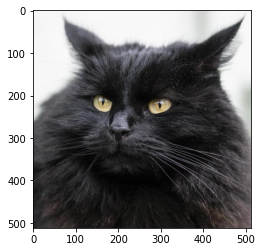

In [ ]:
predict_by_path('/content/arch/afhq/val/cat/flickr_cat_000096.jpg', model)

## Вывод

В данной тетрадке были созданы модели мультиклассовой классификации. На три класса: котики, собачки и дикие животные. 

В данной тетрадке:

1. Предварительно были вычислены средние и дисперсии по выборке обучающего датасета на одном батче для последующего применения.

2. С помощью библиотеки albumentations в обучающий датасет были доблены дополнительные аугментации.

3. Создана и обучена самописная сверточная нейронная сеть, которая показала неплохие результаты (accuracy = 0.96 на валидации).

4. Была импортирована предобученная нейронная сеть vgg16 из pytorch. Было заморожено протекание градиента по нейронной сети, после чего классификатор модели (несколько последних линейных слоев) был заменен на необходимые нам 5 линейных слоев с примененем Dropout и ReLu.  Веса менялись только в новых слоях. 

5. Дообученная под нашу задачу модель VGG16 показала практически идеальные результаты на обучении и валидации, однако эти результаты не подтвердились ручной проверкой (см. послдений раздел с фотографиями).

6. Была импортирована предобученная нейронная сеть AlexNet из pytorch. Протекание градиента по нейронной сети НЕ БЫЛО заморожено. Был заменен последний линейный слой на линейный с количеством выходов, равным три. 

7. Дообученная под нашу задачу модель AlexNet также показала практически идеальные результаты на обучении и валидации, однако эти результаты не подтвердились ручной проверкой.

8. Нейронные сети были сохранены в отдельный файл и в следующей ячейке загружены в новый экземпляр, как того требовало задание.

9. В целом тот факт, что дообученная нейронная сеть показывает результат хуже, чем наша самописная нейронка, не какжется странным. Мы учили все "под себя", а vgg16 учился на imagenet, где 1000 классов. Однако тот факт, что метрики высокие, а в действительности модель работает плохо - остается загадкой. Возможно, все дело в аугментации.